<a href="https://colab.research.google.com/github/LShahmiri/Computer_vision-Image_processing_Projects/blob/master/Grad_cam/Grad_cam_finall.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import numpy as np
import keras
from keras.applications.imagenet_utils import decode_predictions
import skimage.io
import skimage.segmentation
import copy
import sklearn
import sklearn.metrics
from sklearn.linear_model import LinearRegression
import warnings
import matplotlib.pyplot as plt
print('Notebook running: keras ', keras.__version__)
np.random.seed(222)

Notebook running: keras  2.12.0


In [ ]:
import os

import tensorflow as tf
from tensorflow import keras

print(tf.version.VERSION)


2.12.0


In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/xception_20221217-204221_best_model.hdf5')

# Check its architecture
#new_model.summary()

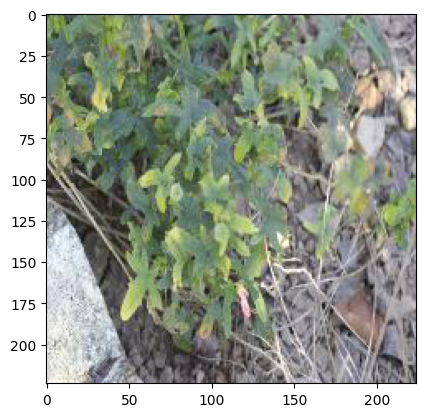

In [ ]:
# Import the necessary modules for image processing using TensorFlow's Keras.
from tensorflow.keras.preprocessing import image

# Specify the file path of the image you want to load and process.
img_path = '/content/drive/MyDrive/wavlet-preprocessing/pure-emgmmpca-selection/Test/Abelmoschus sagittifolius/66.JPG'

# Load the image from the specified path and resize it to the target size of (224, 224) pixels.
img = image.load_img(img_path, target_size=(224, 224))

# Convert the loaded image to a NumPy array for further processing.
img_array = image.img_to_array(img)

# Display the image using matplotlib's imshow function after converting the pixel values to unsigned integers (uint8).
plt.imshow(img_array.astype('uint8'))

# Show the plot with the image visualization.
plt.show()


In [ ]:
# Import the necessary modules and functions for additional preprocessing.
import numpy as np
import tensorflow as tf

# Assuming 'img_array' contains the NumPy array representation of the image.

# Add an extra dimension to the 'img_array' to convert it into a batch of a single image.
img_array = np.expand_dims(img_array, axis=0)

# Preprocess the image data for Xception model.
# Xception model-specific preprocessing includes scaling pixel values and
# converting the color channels from RGB to BGR, among other operations.
# This is typically done before passing the image through the Xception model.
img_array = tf.keras.applications.xception.preprocess_input(img_array)


In [ ]:
def get_cam(model, img_array, class_index, last_conv_layer_name):
    # Create a new model that outputs the activations of the last convolutional layer
    # and the final predictions of the original model.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])

    # Start recording the gradient operations.
    with tf.GradientTape() as tape:
        # Get the activations of the last convolutional layer and the model predictions.
        conv_output, predictions = grad_model(img_array)

        # Select the predicted probability for the specified class index.
        loss = predictions[:, class_index]

        # Calculate the gradients of the predicted probability with respect to the convolutional layer output.
        grads = tape.gradient(loss, conv_output)

        # Calculate the global average pooling of the gradients over all spatial locations.
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Get the output of the last convolutional layer for the first (and only) image in the batch.
    conv_output = conv_output[0]

    # Compute the class activation heatmap by multiplying the pooled gradients with the convolutional output.
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_output), axis=-1)

    # ReLU-like activation to keep only positive values in the heatmap.
    heatmap = np.maximum(heatmap, 0)

    # Normalize the heatmap to have values between 0 and 1.
    heatmap /= np.max(heatmap)

    # Reshape the heatmap to match the spatial dimensions of the original image.
    heatmap = heatmap.reshape((heatmap.shape[0], heatmap.shape[1]))

    # Return the class activation heatmap.
    return heatmap


In [ ]:
# Assuming you have defined the 'model', 'img_array', and 'get_cam' function as described earlier.

# Set the index of the class you want to visualize in the CAM.
class_index = 1

# Specify the name of the last convolutional layer in the Xception model.
# This layer will be used to generate the class activation heatmap.
last_conv_layer_name = 'block14_sepconv2_act'

# Generate the class activation heatmap using the 'get_cam' function.
heatmap = get_cam(model, img_array, class_index, last_conv_layer_name)


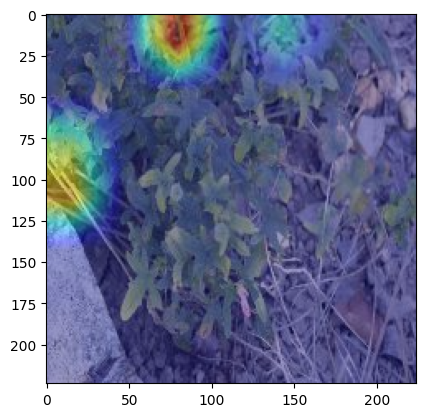

In [ ]:
# Assuming you have already defined 'img_path' and 'heatmap'.

# Read the original image using OpenCV.
img = cv2.imread(img_path)

# Resize the heatmap to match the dimensions of the original image.
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

# Convert the heatmap values to the range [0, 255] as it will be used for color mapping.
heatmap = np.uint8(255 * heatmap)

# Apply a color map (here, the Jet colormap) to convert the grayscale heatmap to a colored one.
colored_heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# Superimpose the colored heatmap on the original image using a weighted sum.
# The parameter 0.6 determines the transparency of the original image,
# and 0.4 determines the transparency of the heatmap.
# This creates an effect of the heatmap being overlaid on the image.
superimposed_img = cv2.addWeighted(img, 0.6, colored_heatmap, 0.4, 0)

# Display the superimposed image with the heatmap visualization.
# Since OpenCV reads images in BGR format, we need to convert it to RGB for visualization using matplotlib.
plt.imshow(superimposed_img[...,::-1])
plt.show()
